In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import mayavi

## Create functions for the physical setup (table with gaps and tilted camera recorder)

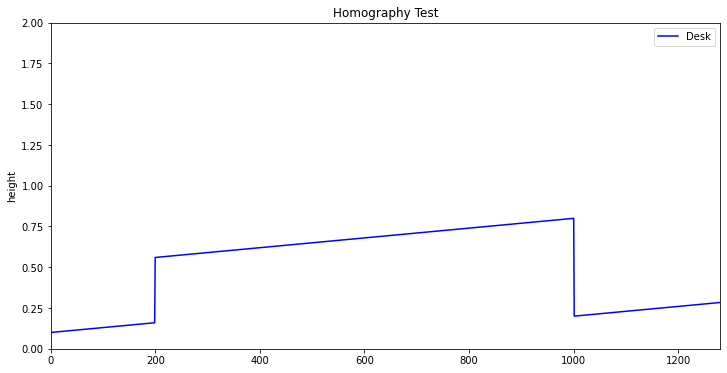

In [2]:
#def fn_tilted_desk_helper(x, m=-0.0003, b=0.8):
def fn_tilted_desk_helper(x, m=0.0003, b=0.5):    
    # create a line
    line = m * x + b
    # cut out holes on both sides
    pos1 = 200
    pos2 = 1080
    r = 200
    ret = line
    if x < 200:
        ret = line - 0.4
    elif x > 1000:
        ret = line - 0.6
    return ret

def fn_tilted_desk(xs):
    return [ fn_tilted_desk_helper(x) for x in xs ]

def fn_line(x, m=0.0005, b=0.5):
    return m * x + b

# Some constants
SCREEN_SIZE_X = 1280

# create samples from function
xs = np.arange(0, SCREEN_SIZE_X, 1.0)
y1 = fn_tilted_desk(xs) # tilted table
y_threshold = fn_line(xs, m=0.0, b=0.45)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('height')
ax.set_title('Homography Test')
ax.plot(y1, color='blue', label='Desk')
#ax.plot(y_threshold, color='red', label='Threshold', linestyle='dashed')
plt.xlim([0, SCREEN_SIZE_X])
plt.ylim([0, 2.0])
plt.legend()
plt.show()

# Get homography by sampling around the center

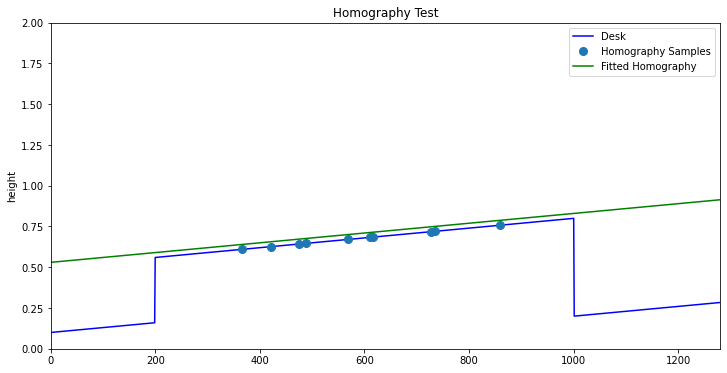

In [3]:
center = (300, 900)
sample_size = 10
h_samples_x = np.random.randint(center[0], center[1], sample_size)
h_samples_y = fn_tilted_desk(h_samples_x)
#print('Random sampled values:', list(zip(h_samples_x, h_samples_y)))

A = np.vstack([h_samples_x, np.ones(len(h_samples_x))]).T
m, c = np.linalg.lstsq(A, h_samples_y, rcond=None)[0]
y_fitted = m * xs + c + 0.03

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('height')
ax.set_title('Homography Test')
ax.plot(y1, color='blue', label='Desk')
#ax.plot(y_threshold, color='red', label='Threshold', linestyle='dashed')
plt.xlim([0, SCREEN_SIZE_X])
plt.ylim([0, 2.0])
plt.plot(h_samples_x, h_samples_y, 'o', label='Homography Samples', markersize=8)
plt.plot(xs, y_fitted, color='green', label='Fitted Homography')
plt.legend()
plt.show()

## Projection

0.00029999999096152054 0.01718873333605797
[[0.999999955000003, 0.000299999986461521], [-0.000299999986461521, 0.999999955000003]]


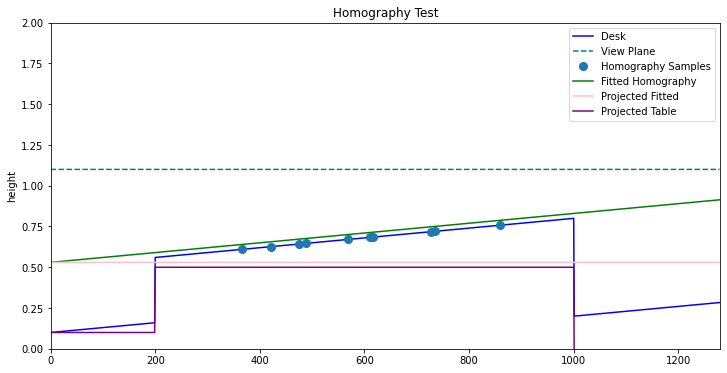

In [4]:
# m * xs + c

view_plane_height = 1.1
y_view_plane = fn_line(xs, m=0.0, b=view_plane_height)
#h_mat_view_plane = np.matrix([[0, h_view_plane], [1, h_view_plane]])
#h_mat_plane = np.matrix([[],[]])
h_rot_pt = (SCREEN_SIZE_X, view_plane_height)
if y_fitted[0] > y_fitted[SCREEN_SIZE_X-1]:
    h_rot_pt = [ xs[0], y_fitted[0] ]
    h_end_pt = [ xs[SCREEN_SIZE_X-1], y_fitted[SCREEN_SIZE_X-1] ]
else:
    h_rot_pt = [ xs[SCREEN_SIZE_X-1], y_fitted[SCREEN_SIZE_X-1] ]
    h_end_pt = [ xs[0], y_fitted[0] ]    
#print(h_rot_pt, h_end_pt)

np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, formatter=dict(float=lambda x: "%.3f" % x))

view_plane_vector = np.float32([SCREEN_SIZE_X, 0])
fitted_plane_vector = np.float64([
    xs[SCREEN_SIZE_X-1] - xs[0], 
    y_fitted[SCREEN_SIZE_X-1] - y_fitted[0]
])

def unit_vector(vector):
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
angle = angle_between(view_plane_vector, fitted_plane_vector)
phi = np.deg2rad(angle)
print(phi, angle)
# 2d case only according to x direction
if fitted_plane_vector[1] < 0:
    rot_mat = [[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]]
else:
    # we should add x here ...
    rot_mat = [[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]]
print(rot_mat)
rows = np.float64(list(zip(xs, y_fitted)))
y_fitted_projected = [[],[]]
for row in rows:
    y_fitted_projected = np.hstack([y_fitted_projected, rot_mat @ np.vstack(row)])

#print(y_fitted_projected)
    
#print(cv.phase(np.float32(h_samples_x), np.float32(h_samples_y), angleInDegrees=True))

#x_samples = np.random.randint(0, SCREEN_SIZE_X, sample_size)
#src_pts = np.float64([ [x, y_fitted[x]] for x in x_samples ])
#dst_pts = np.float64([ [x, y_view_plane[x]] for x in x_samples ])
#print(src_pts)
#print(dst_pts)
#print(dst_pts)
#M, mask = cv.findHomography(src_pts, dst_pts)
#matchesMask = mask.ravel().tolist()
#print(M, mask, matchesMask)
#print(cv.getPerspectiveTransform(src_pts, dst_pts))

table_stacked = np.vstack(list(zip(xs, y1)))
y_table = [[],[]]
for row in table_stacked:
    y_table = np.hstack([y_table, rot_mat @ np.vstack(row)])

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('height')
ax.set_title('Homography Test')
ax.plot(y1, color='blue', label='Desk')
#ax.plot(y_threshold, color='red', label='Threshold', linestyle='dashed')
ax.plot(y_view_plane, color='teal', label='View Plane', linestyle='dashed')
#ax.arrow(0.0, 0.0, view_plane_vector[0] * 500, view_plane_vector[1], color='gold', head_width=0.05, head_length=0.1, linestyle=':')
#ax.arrow(0.0, 0.0, fitted_plane_vector[0], fitted_plane_vector[1], color='gold', head_width=0.05, head_length=0.1, linestyle=':')
plt.xlim([0, SCREEN_SIZE_X])
plt.ylim([0, 2.0])
plt.plot(h_samples_x, h_samples_y, 'o', label='Homography Samples', markersize=8)
plt.plot(xs, y_fitted, color='green', label='Fitted Homography')
plt.plot(y_fitted_projected[0], y_fitted_projected[1], color='pink', label='Projected Fitted')
plt.plot(y_table[0], y_table[1], color='purple', label='Projected Table')
plt.legend()
plt.show()

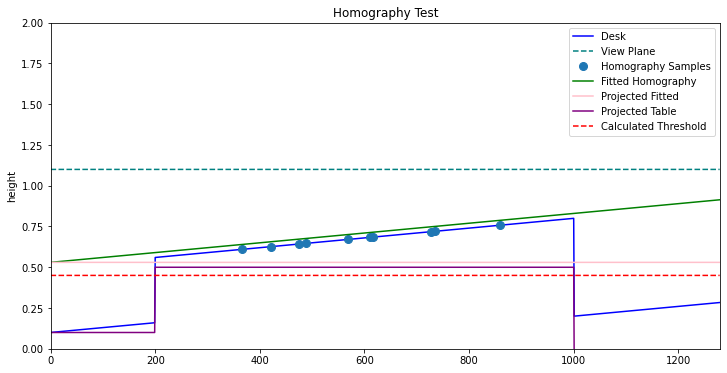

In [5]:
# get center point of table as line and substract some small value
y_center_point = y_table[1][int(SCREEN_SIZE_X / 2)]
y_threshold = np.repeat(y_center_point, SCREEN_SIZE_X)
y_threshold -= 0.05

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('height')
ax.set_title('Homography Test')
ax.plot(y1, color='blue', label='Desk')
ax.plot(y_view_plane, color='teal', label='View Plane', linestyle='dashed')
#ax.arrow(0.0, 0.0, view_plane_vector[0] * 500, view_plane_vector[1], color='gold', head_width=0.05, head_length=0.1, linestyle=':')
#ax.arrow(0.0, 0.0, fitted_plane_vector[0], fitted_plane_vector[1], color='gold', head_width=0.05, head_length=0.1, linestyle=':')
plt.xlim([0, SCREEN_SIZE_X])
plt.ylim([0, 2.0])
plt.plot(h_samples_x, h_samples_y, 'o', label='Homography Samples', markersize=8)
plt.plot(xs, y_fitted, color='green', label='Fitted Homography')
plt.plot(y_fitted_projected[0], y_fitted_projected[1], color='pink', label='Projected Fitted')
plt.plot(y_table[0], y_table[1], color='purple', label='Projected Table')
ax.plot(y_threshold, color='red', label='Calculated Threshold', linestyle='dashed')
plt.legend()
plt.show()

In [ ]:
#%matplotlib inline
%matplotlib qt

#xx, yy = np.meshgrid(range(3), range(3))
#z = yy - xx

xx = np.float64([1,2,3,4,5])
yy = np.float64([1,5,9,4,5.01])
zz = np.float64([1,2,9,4,5])
A = np.vstack([[xx, yy], np.ones(len(xx))]).T
a, b, c = np.linalg.lstsq(A, zz, rcond=None)[0]
#print(a,b,c)

# is the same
ret, dst = cv.solve(A, zz, flags=cv.DECOMP_SVD)
#print(ret, dst)

mx, my = np.meshgrid(range(15), range(15))
mz = a*mx + b*my + c

get_mz = lambda x,y: a*x + b*y + c

# Viewing plane
xx2, yy2 = np.meshgrid(range(15), range(15))
zz2 = np.zeros((15,15))

# https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d

uv_table = unit_vector([a,b,c])
uv_view = unit_vector([0,0,1])
cos_phi = np.dot(uv_table, uv_view)
sin_phi = np.linalg.norm(np.cross(uv_table, uv_view))
#print(uv_table)
#print(uv_view)
#print(cos_phi)
#print(sin_phi)
G = np.float64([[cos_phi, -sin_phi, 0], [sin_phi, cos_phi, 0], [0,0,1]])
print('G', G)

# Rodriguez
v = np.cross(uv_table, uv_view)
sin_angle = np.linalg.norm(v)
cos_angle = np.dot(uv_table, uv_view)
v_skew = np.float64([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
G = np.eye(3) + v_skew + ((v_skew**2) * (1/(1+cos_angle)))
print('G2', G)

# Opencv works
print(get_mz(100, 100))
cv_from = np.float64([
    [100, 100,  get_mz(100, 100)],
    [-100, -100, get_mz(-100, -100)],
    [-100, 100, get_mz(-100, 100)],
    [100, -100, get_mz(100, -100)]
])
cv_to = np.float64([
    [100, 100, 0],
    [-100, -100, 0],
    [-100, 100, 0],
    [100, -100, 0]
])
print(cv_from.shape)
print(cv_to.shape)
(G, out) = cv.findHomography(cv_from, cv_to)
print(G)
print(out)


#rows = np.float64(list(zip(mx, my, mz)))
m_projected = np.zeros((3,15,15))
for i in range(15):
    for j in range(15):
        x = mx[i,j]
        y = my[i,j]
        z = mz[i,j]
        proj = G @ np.float64([x,y,z]).T
        m_projected[0,i,j] = x
        m_projected[1,i,j] = y
        m_projected[2,i,j] = proj[2]
        #m_projected = np.hstack([m_projected, G @ np.vstack(row)])
    

# Looks ugly
#ax = plt.axes(projection='3d')
#ax.scatter(xx, yy, zz, label='')
#ax.plot_surface(xx2, yy2, zz2, rstride=1, cstride=1, color='r', shade=False, edgecolor='none', alpha=1.)
#ax.plot_surface(mx, my, mz, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=1.)
#ax.set_title('surface')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#ax.legend()

# Looks good :>
from mayavi import mlab
fig = mlab.figure(bgcolor=(.7,.7,.7))
mlab.quiver3d([[7.5]], [[7.5]], [[uv_table[0]*7.5+(uv_table[1]*7.5)+uv_table[2]]], [[uv_table[0]*10]], [[uv_table[1]*10]], [[uv_table[2]*10]], color=(0,1,0), line_width=2.0, scale_factor=1.0)
mlab.quiver3d([[7.5]], [[7.5]], [[0]], [[uv_view[0]*10]], [[uv_view[1]*10]], [[uv_view[2]*10]], color=(0,1,0), line_width=2.0, scale_factor=1.0)
mlab.points3d([xx], [yy], [zz], color=(.8,.8,1), scale_factor=0.6)
mlab.mesh(xx2, yy2, zz2, color=(1,0,0))
mlab.mesh(m_projected[0], m_projected[1], m_projected[2], colormap='viridis')
mlab.mesh(mx, my, mz, colormap='viridis')
mlab.axes(color=(1.,1.,1.), xlabel='x', ylabel='y', zlabel='z')
mlab.outline(color=(1.,1.,1.))
mlab.orientation_axes()
mlab.yaw(135)
mlab.view(elevation=None, distance=70, roll=90)
#mlab.title('Homography')
mlab.outline()
mlab.show()

G [[-0.785 -0.619 0.000]
 [0.619 -0.785 0.000]
 [0.000 0.000 1.000]]
G2 [[1.000 0.000 0.019]
 [0.000 1.000 0.960]
 [0.484 2.108 1.000]]
125.69040652833036
(4, 3)
(4, 3)
[[-1.236 0.000 -0.000]
 [0.000 -1.236 0.000]
 [-0.366 -0.904 1.000]]
[[1]
 [1]
 [1]
 [1]]


multiple 'pyface.toolkits' plugins found for toolkit 'qt4': pyface.ui.qt4.init, pyface.ui.qt4.init
